# imports

In [1]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import experiment as exp
import model as m
import plot
import predict
import runner2 as r

import numpy as np
import matplotlib.pyplot as plt

import os
import torch

import umap
import matplotlib
from sklearn.preprocessing import StandardScaler

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

_ = plt.rcParams['axes.grid'] = False # turn off grid

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

Invoking __init__.py for NDNT.utils


/home/mattjac/anaconda3/envs/pytorch2/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mattjac/anaconda3/envs/pytorch2/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mattjac/anaconda3/envs/pytorch2/lib/python3.11/site-packag

In [2]:
e = exp.load('iter_exps10', experiment_location='experiments', datadir='Mdata')
np.mean(e.trials[0].LLs)

0.10018215

In [3]:
dataset = e.trials[0].dataset
expt_boundaries = np.concatenate([[0], np.cumsum(dataset.num_units)])
expt_boundaries

lazy loading dataset
Loading expt04
  Time embedding...
  Done.
Loading expt06
  Time embedding...
  Done.
Loading expt09
  Time embedding...
  Done.
Loading expt11
  Time embedding...
  Done.


array([  0,  35,  63,  86, 111])

# readout weights

(68, 111)


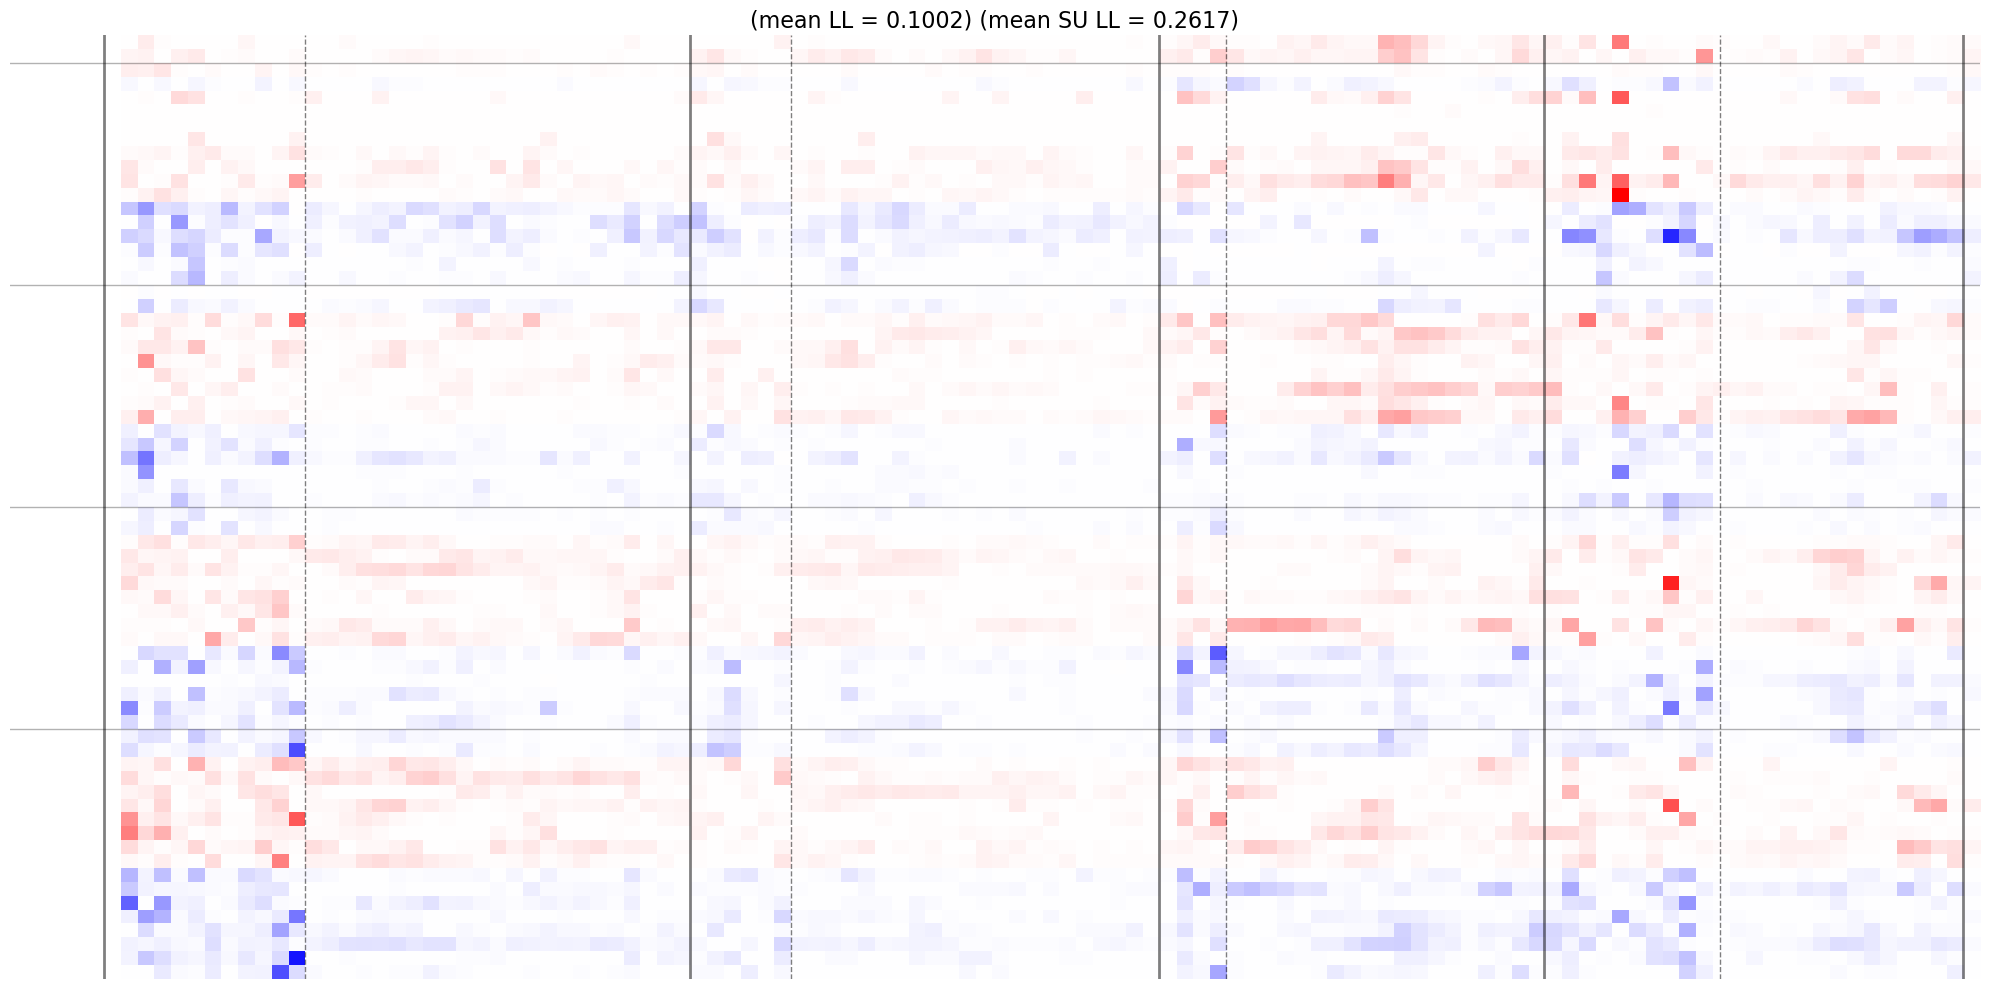

In [12]:
readout_weights = np.sum(e.trials[0].model.networks[-1].layers[-1].weights[:,:,:], axis=1)
print(readout_weights.shape)
# make inhibitory weights negative (every 12 weights need to be flipped)
readout_weights[3,:] = -readout_weights[3,:]
for i in range(12,readout_weights.shape[0],16):
    readout_weights[i:i+8,:] = -readout_weights[i:i+8,:]

# get the mean LLs for just the SUs in k
mean_SU_LLs = np.mean(e.trials[0].LLs[dataset.SUs])

# get the mean LLs for k
mean_LLs = np.mean(e.trials[0].LLs)

fig = plt.figure(figsize=(20,10))
plot.imagesc(readout_weights, cmap='bwr', colrow=False, origin='upper')
plt.title('(mean LL = %.4f)' % mean_LLs + ' (mean SU LL = %.4f)' % mean_SU_LLs, fontsize=16)
plt.axis('off')

# put a vertical line between each experiment
for expt_boundary in expt_boundaries:
    plt.axvline(expt_boundary-1-0.5, color='k', linewidth=2, alpha=0.5)

# put a vertical line between the SUs and the MUs
# get the indices of the SUs where the experiment boundaries are
SU_boundaries = np.where(np.diff(dataset.SUs) > 1)[0]

for SU_boundary in SU_boundaries:
    plt.axvline(dataset.SUs[SU_boundary]+1-0.5, color='k', linewidth=1, alpha=0.5, linestyle='--')
# plot the last SU boundary
plt.axvline(dataset.SUs[-1]+1, color='k', linewidth=1, alpha=0.5, linestyle='--')

layer_boundaries = [0, 2, 18, 34, 50, 66]

# put a horizontal line between each layer
for layer_boundary in layer_boundaries[1:-1]:
    plt.axhline(layer_boundary-0.5, color='k', linewidth=1, alpha=0.3)

plt.tight_layout()
plt.show()

# neuron readout weights

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


Readout weights shape (68, 36, 111)


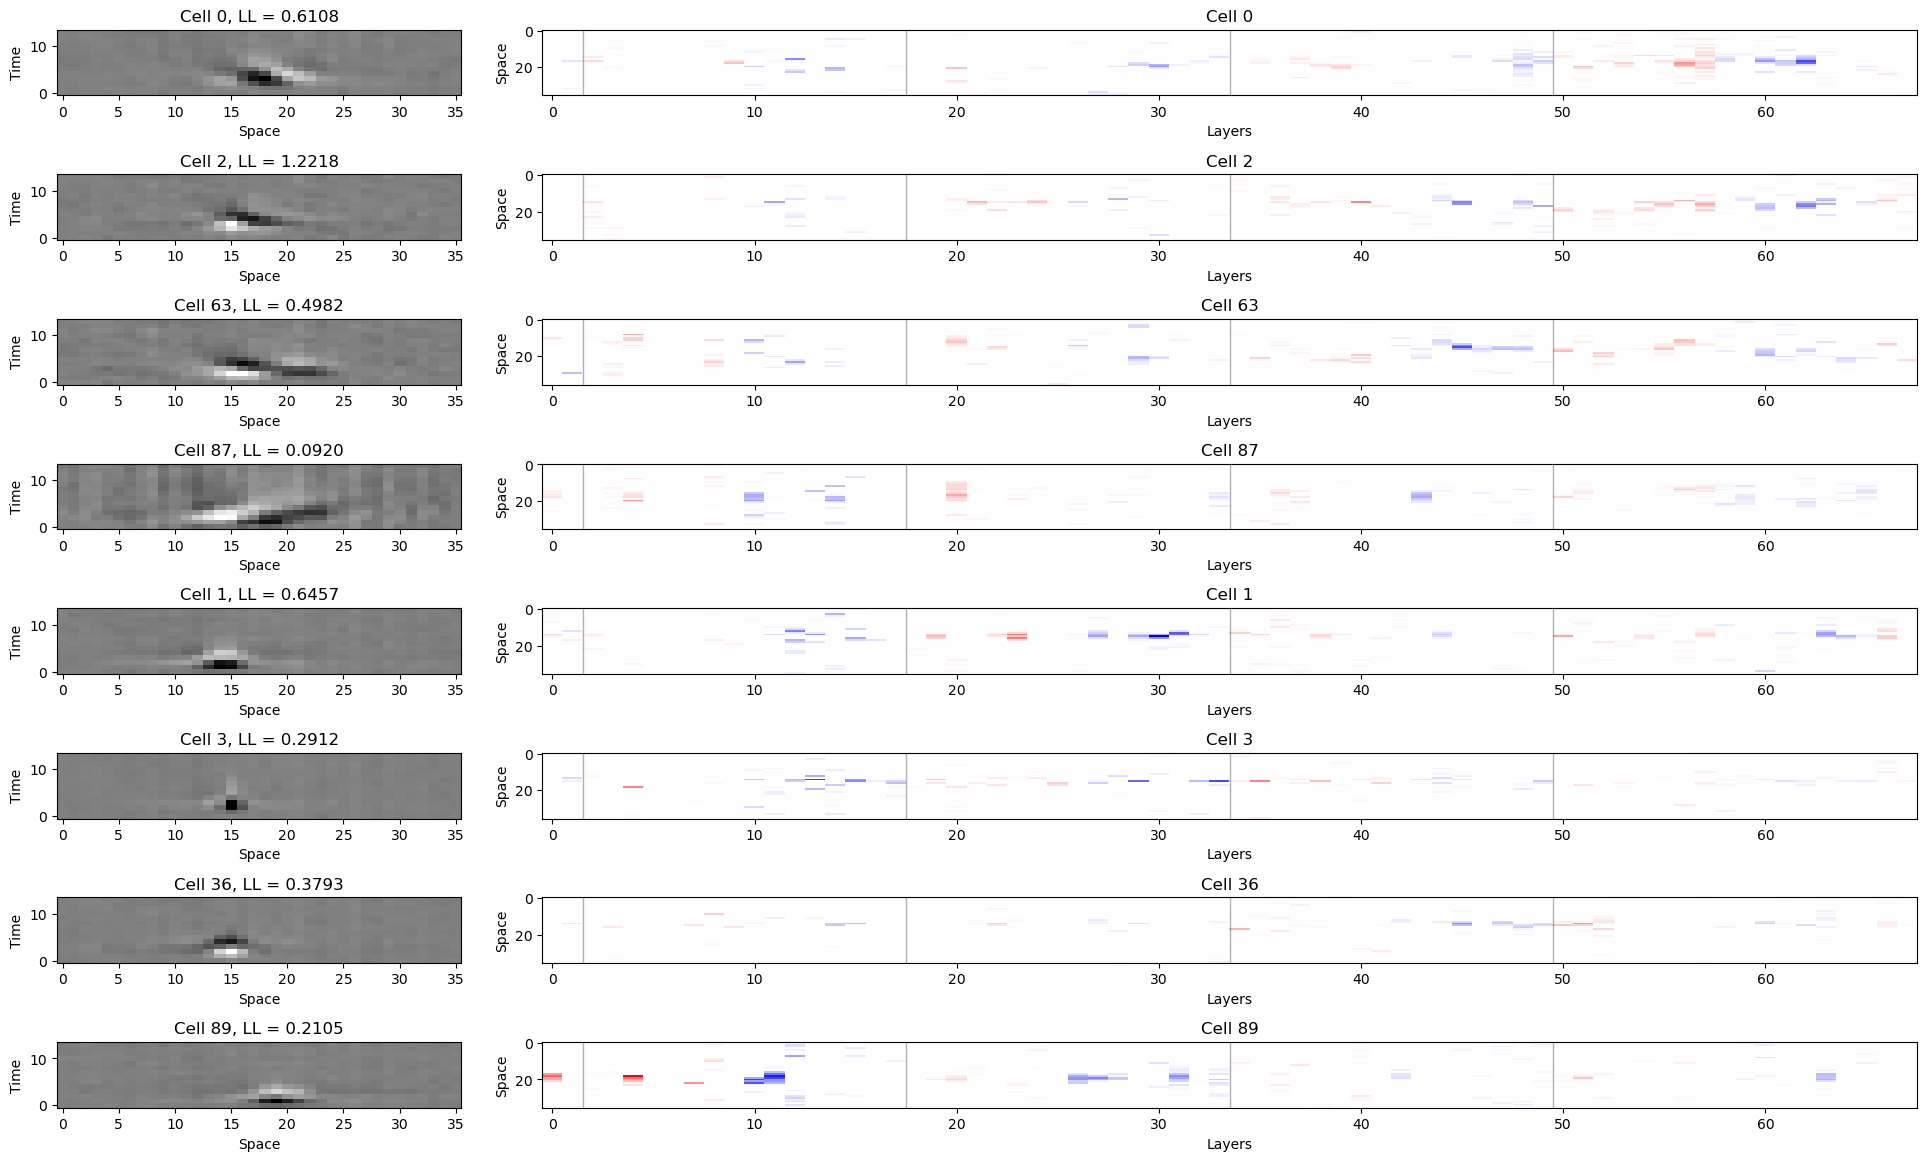

In [16]:
dirsel_neurons = [0, 2, 63, 87] + [1, 3, 36, 89]

preds = predict.calc_preds(dataset, e.trials[0].model, end=50000, batch_size=5000)
stas, pred = predict.calc_STAs(dataset, preds, end=50000)

# get the weights
readout_weights = e.trials[0].model.networks[1].layers[0].weights
print('Readout weights shape', readout_weights.shape)
readout_weights[1,:,:] = -readout_weights[1,:,:]
for i in range(10,readout_weights.shape[0],16):
    readout_weights[i:i+8,:,:] = -readout_weights[i:i+8,:,:]

pred_max = np.max(pred[:,:,dirsel_neurons])
pred_min = -pred_max

readout_max = np.max(readout_weights[:,:,dirsel_neurons])
readout_min = -readout_max

fig = plt.figure(figsize=(24,14))
rows,cols = len(dirsel_neurons),4
gridspec = fig.add_gridspec(rows,cols)
# put vertical space between the plots
gridspec.update(wspace=0.2, hspace=1.2)

cc = 0
for cc in range(len(dirsel_neurons)):
    ax = fig.add_subplot(gridspec[cc,0])
    plot.imagesc(pred[:,:,dirsel_neurons[cc]], cmap='gray', ax=ax)
    ax.set_title('Cell '+str(dirsel_neurons[cc])+', LL = %.4f' % e.trials[0].LLs[dirsel_neurons[cc]])
    ax.set_xlabel('Space')
    ax.set_ylabel('Time')

    ax = fig.add_subplot(gridspec[cc,1:])
    ax.imshow(readout_weights[:,:,dirsel_neurons[cc]].T, cmap='bwr', aspect='auto', vmin=readout_min, vmax=readout_max, interpolation='none')
    ax.set_xlabel('Layers')
    ax.set_ylabel('Space')
    ax.set_title('Cell '+str(dirsel_neurons[cc]))

    # draw a vertical line between each layer
    for layer_boundary in layer_boundaries[1:-1]:
        # shift the line back by 0.5
        ax.axvline(layer_boundary-0.5, color='k', linewidth=1, alpha=0.3)

    cc += 1

In [4]:
import pickle

with open('results_iter_exps12_3iters_outputs.pkl', 'rb') as f:
    results_outputs = pickle.load(f)

In [5]:
class ResultsJacobian:
    def __init__(self, jacobian, times):
        self.jacobian = jacobian

with open('results_iter_exps12_3iters_jacobians.pkl', 'rb') as f:
    results_jacobians = pickle.load(f)

# PCA

In [6]:
import umap
import hdbscan
from sklearn.decomposition import PCA


cluster_labels = []
i = 0
for ni in range(len(results_outputs.outputs)-1): # skip the 'readout' layer
    for li in range(len(results_outputs.outputs[ni])):
        if li < 2:
            for subunit in range(results_outputs.outputs[ni][li].shape[1]):
                imax = np.max(results_jacobians[i].jacobian.jacobians[0][0][:,subunit,17,0])
                imin = -imax
                print('ni', ni, 'li', li, 'subunit', subunit)
                jacobians = results_jacobians[i].jacobian.jacobians[0][0][:,subunit,17,0]
                # normalize the jacobians
                jacobians = (jacobians - imin) / (imax - imin)

                # cluster the jacobians
                #lowd_jacobians = umap.UMAP(random_state=42).fit_transform(jacobians)
                lowd_jacobians = PCA(n_components=10).fit_transform(jacobians)
                clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
                clusterer.fit(lowd_jacobians)
                print(clusterer.labels_)
                cluster_labels.append(clusterer.labels_)
                i += 1
        else:
            for iter in range(results_outputs.outputs[ni][li].shape[1]):
                for subunit in range(results_outputs.outputs[ni][li].shape[2]):
                    imax = np.max(results_jacobians[i].jacobian.jacobians[0][0][:,iter,subunit,17,0])
                    imin = -imax
                    print('ni', ni, 'li', li, 'iter', iter, 'subunit', subunit)
                    jacobians = results_jacobians[i].jacobian.jacobians[0][0][:,iter,subunit,17,0]
                    # normalize the jacobians
                    jacobians = (jacobians - imin) / (imax - imin)

                    # cluster the jacobians
                    # lowd_jacobians = umap.UMAP(n_neighbors=30,
                    #                            min_dist=0.0,
                    #                            n_components=2,
                    #                            random_state=42,).fit_transform(jacobians)
                    lowd_jacobians = PCA(n_components=10).fit_transform(jacobians)
                    clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
                    clusterer.fit(lowd_jacobians)
                    print(clusterer.labels_)
                    cluster_labels.append(clusterer.labels_)
                    i += 1

num_clusters = len(np.unique(np.vstack(cluster_labels)))

ni 0 li 0 subunit 0
[0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 1 0
 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1
 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 1 0]
ni 0 li 0 subunit 1
[0 0 1 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 1 1 1 1
 1 1 1 0 0 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 0 1 0]
ni 0 li 0 subunit 2
[0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0
 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1
 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1]
ni 0 li 0 subunit 3
[1 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1
 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0
 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
ni 0 li 1 subunit 0
[ 0  0  1  0  0  2  2  0  2  0 -1  0  0  1  0  0  2  0  0  2  0  2  0  1
  2  0  0  

In [7]:
cluster_labels_to_timepoints = []
for i in range(0, len(cluster_labels)):
    cluster_labels_to_timepoints.append({})
    for j in range(0, len(cluster_labels[i])):
        if cluster_labels[i][j] not in cluster_labels_to_timepoints[i]:
            cluster_labels_to_timepoints[i][cluster_labels[i][j]] = []
        cluster_labels_to_timepoints[i][cluster_labels[i][j]].append(j)

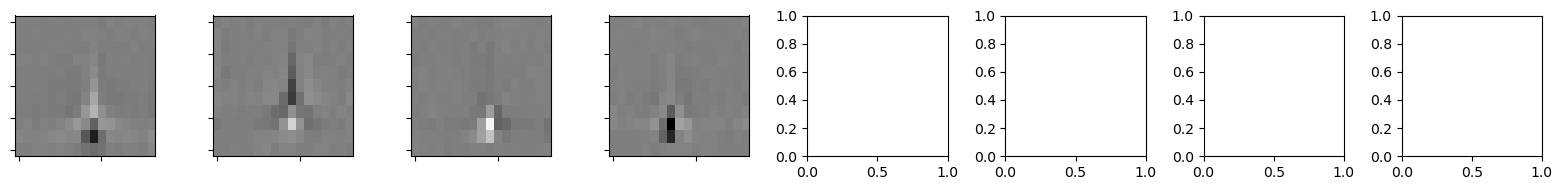

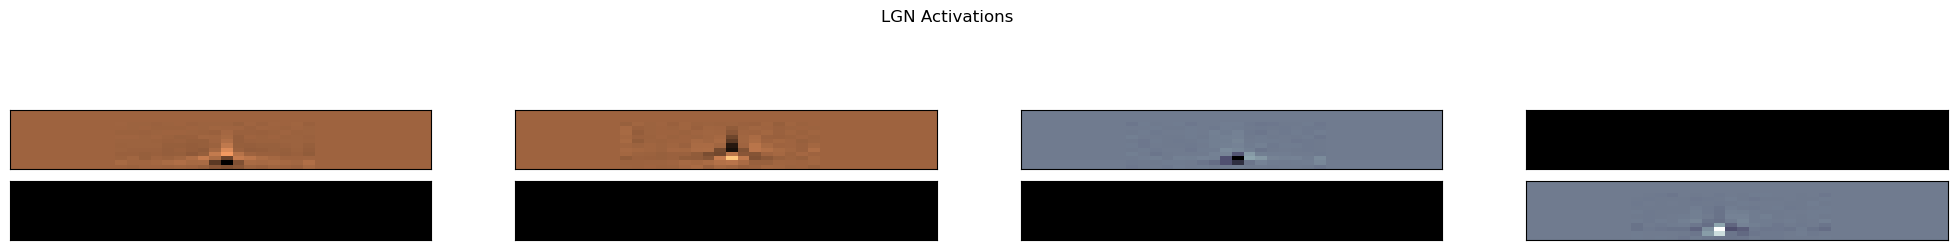

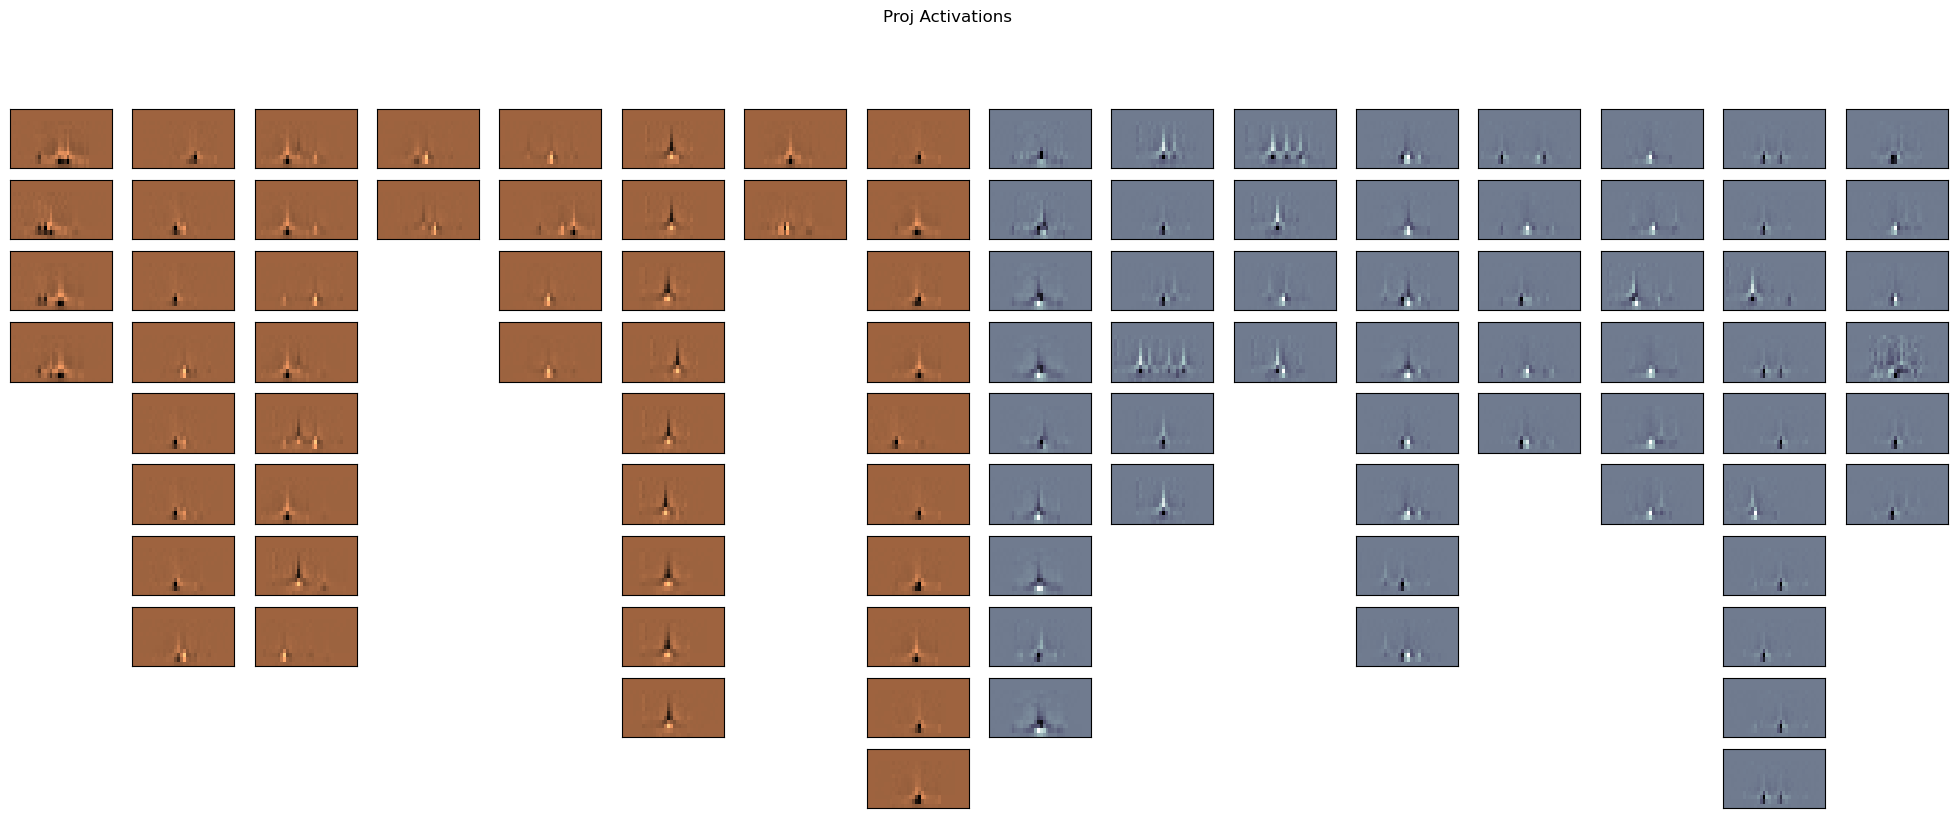

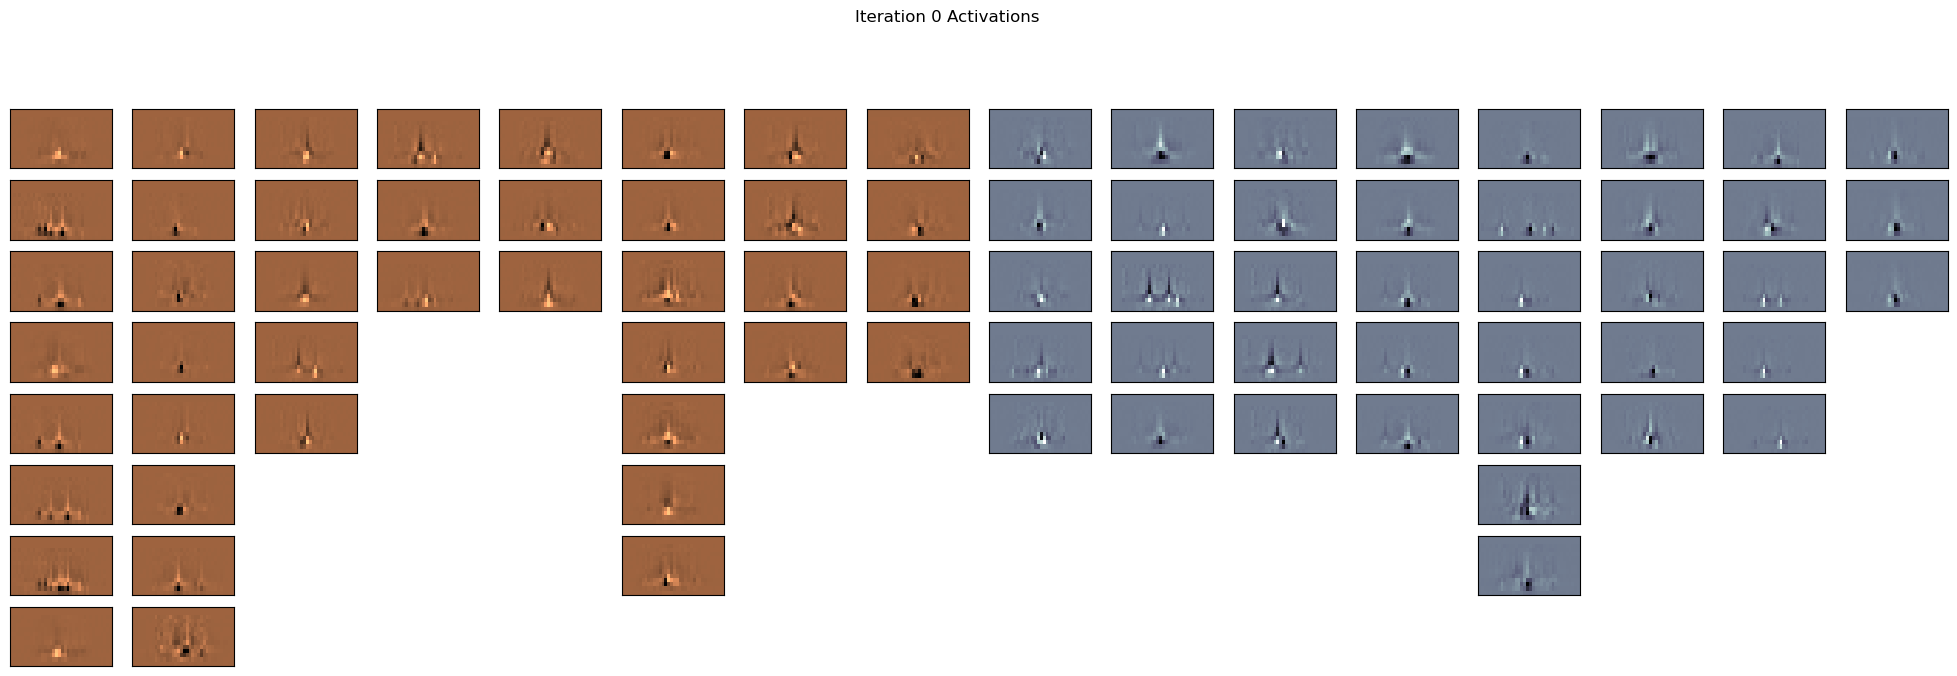

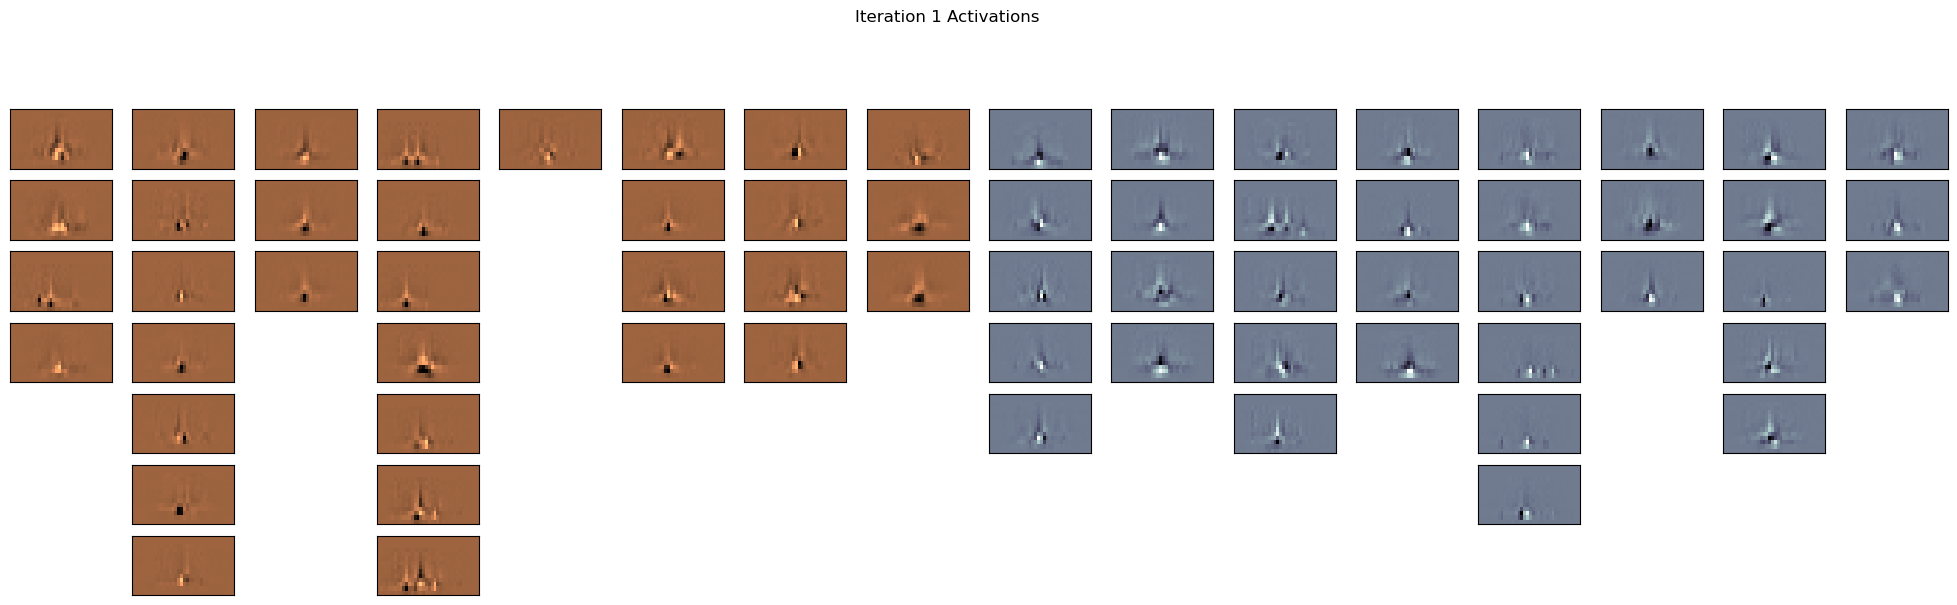

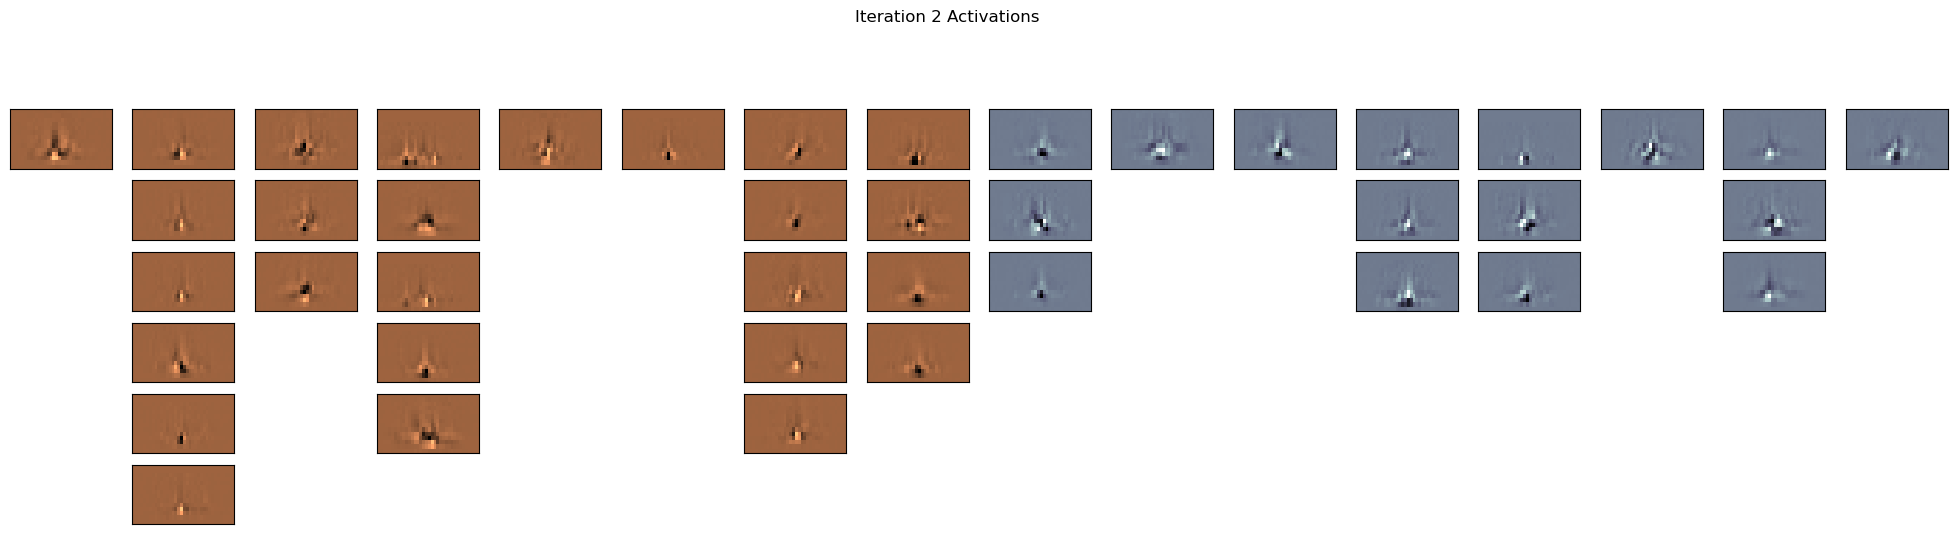

In [9]:
e.trials[0].model.NDN.plot_filters()

i = 0
for ni in range(len(results_outputs.outputs)-1): # skip the 'readout' layer
    for li in range(len(results_outputs.outputs[ni])):
        #fname = 'ni%d_li%d_subunit%d_jacobians.pkl' % (ni, li, subunit)
        #if os.path.exists('./results_iter_exps12_3iters_jacobians/'+fname):
        #    print('##### Network %d Layer %d Lag %d Subunit %d already done #####' % (ni, li, lag, subunit))
        #    continue # skip if already done
        if li < 2:
            num_subunits = results_outputs.outputs[ni][li].shape[1]
            fig = plt.figure(figsize=(25,10))
            grid = matplotlib.gridspec.GridSpec(num_clusters,num_subunits)
            # plot the results jacobian
            imax = np.max(np.vstack([results_jacobians[k].jacobian.jacobians[0][0][:,:,17,0] for k in range(i,i+num_subunits)]))
            imin = -imax
            for subunit in range(num_subunits):
                if subunit >= num_subunits//2: # inhibitory subunits
                    cmap = 'bone'
                else:
                    cmap = 'copper'

                cluster_idx = 0
                for label, cluster in cluster_labels_to_timepoints[i].items():
                    ax = fig.add_subplot(grid[cluster_idx, subunit])
                    im = results_jacobians[i].jacobian.jacobians[0][0][cluster[0],subunit,17,0].reshape(36,14).T
                    plot.imagesc(im.T, cmap=cmap, ax=ax, axis_labels=False)
                    cluster_idx += 1
                    ax.set_xticks([])
                    ax.set_yticks([])
                i += 1
            if li == 0:
                name = 'LGN Activations'
            elif li == 1:
                name = 'Proj Activations'
            plt.suptitle(name)
            plt.show()
        else:
            for iter in range(results_outputs.outputs[ni][li].shape[1]):
                num_subunits = results_outputs.outputs[ni][li].shape[2]
                fig = plt.figure(figsize=(25,10))
                grid = matplotlib.gridspec.GridSpec(num_clusters,num_subunits)
                # plot the results jacobian
                imax = np.max(np.vstack([results_jacobians[k].jacobian.jacobians[0][0][:,iter,:,17,0] for k in range(i,i+num_subunits)]))
                imin = -imax
                for subunit in range(num_subunits):
                    if subunit >= num_subunits//2: # inhibitory subunits
                        cmap = 'bone'
                    else:
                        cmap = 'copper'

                    cluster_idx = 0
                    for label, cluster in cluster_labels_to_timepoints[i].items():
                        ax = fig.add_subplot(grid[cluster_idx, subunit])
                        im = results_jacobians[i].jacobian.jacobians[0][0][cluster[0],iter,subunit,17,0].reshape(36,14).T
                        plot.imagesc(im.T, cmap=cmap, ax=ax, axis_labels=False)
                        cluster_idx += 1
                        ax.set_xticks([])
                        ax.set_yticks([])
                    i += 1
                plt.suptitle('Iteration %d Activations' % iter)
                plt.show()

# wiring diagram

In [103]:
dirsel = dirsel_neurons[1]
nonsel = dirsel_neurons[5]

dirsel_weights = []
for cc in range(len(dirsel_neurons)):
    dirsel_weights.append(readout_weights[:,17,cc])
    # normalize the weights
    dirsel_weights[-1] = dirsel_weights[-1] / np.max(np.abs(dirsel_weights[-1]))

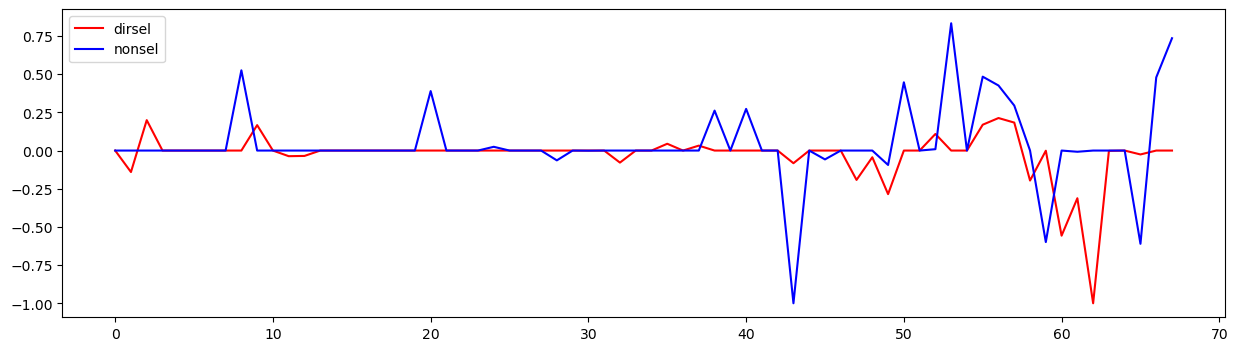

In [104]:
fig = plt.figure(figsize=(15,4))
plt.plot(dirsel_weights[0], color='r', label='dirsel')
plt.plot(dirsel_weights[5], color='b', label='nonsel')
plt.legend()
plt.show()

In [108]:
# def plot_jacobians(units_to_show=None, neuron=None):
#     if neuron is not None:
#         fig = plt.figure(figsize=(2,1))
#         plot.imagesc(pred[:,:,neuron], cmap='gray')
#         plt.title('Cell '+str(neuron)+', LL = %.4f' % e.trials[0].LLs[neuron])
#         plt.xlabel('Space')
#         plt.ylabel('Time')
#         plt.show()
#     
#     i = 0
#     for ni in range(len(results_outputs.outputs)-1): # skip the 'readout' layer
#         for li in range(len(results_outputs.outputs[ni])):
#             #fname = 'ni%d_li%d_subunit%d_jacobians.pkl' % (ni, li, subunit)
#             #if os.path.exists('./results_iter_exps12_3iters_jacobians/'+fname):
#             #    print('##### Network %d Layer %d Lag %d Subunit %d already done #####' % (ni, li, lag, subunit))
#             #    continue # skip if already done
#             if li < 2:
#                 num_subunits = results_outputs.outputs[ni][li].shape[1]
#                 fig = plt.figure(figsize=(25,10))
#                 grid = matplotlib.gridspec.GridSpec(num_clusters,num_subunits)
#                 # plot the results jacobian
#                 imax = np.max(np.vstack([results_jacobians[k].jacobian.jacobians[0][0][:,:,17,0] for k in range(i,i+num_subunits)]))
#                 imin = -imax
#                 for subunit in range(num_subunits):
#                     if subunit >= num_subunits//2: # inhibitory subunits
#                         cmap = 'bone'
#                     else:
#                         cmap = 'copper'
#                         
#                     if units_to_show is None or i in units_to_show:
#                         cluster_idx = 0
#                         for label, cluster in cluster_labels_to_timepoints[i].items():
#                             ax = fig.add_subplot(grid[cluster_idx, subunit])
#                             ax.set_xticks([])
#                             ax.set_yticks([])
#                             im = results_jacobians[i].jacobian.jacobians[0][0][cluster[0],subunit,17,0].reshape(36,14)
#                             plot.imagesc(im, cmap=cmap, ax=ax, axis_labels=False)
#                             cluster_idx += 1
#                     else:
#                         # show a blank image
#                         ax = fig.add_subplot(grid[0, subunit])
#                         ax.set_xticks([])
#                         ax.set_yticks([])
#                         ax.imshow(np.zeros((36,14)).T, cmap=cmap)
#                     i += 1
#                 if li == 0:
#                     name = 'LGN Activations'
#                 elif li == 1:
#                     name = 'Proj Activations'
#                 plt.suptitle(name)
#                 plt.show()
#             else:
#                 for iter in range(results_outputs.outputs[ni][li].shape[1]):
#                     num_subunits = results_outputs.outputs[ni][li].shape[2]
#                     fig = plt.figure(figsize=(25,10))
#                     grid = matplotlib.gridspec.GridSpec(num_clusters,num_subunits)
#                     # plot the results jacobian
#                     imax = np.max(np.vstack([results_jacobians[k].jacobian.jacobians[0][0][:,iter,:,17,0] for k in range(i,i+num_subunits)]))
#                     imin = -imax
#                     for subunit in range(num_subunits):
#                         if subunit >= num_subunits//2: # inhibitory subunits
#                             cmap = 'bone'
#                         else:
#                             cmap = 'copper'
# 
#                         if units_to_show is None or i in units_to_show:
#                             cluster_idx = 0
#                             for label, cluster in cluster_labels_to_timepoints[i].items():
#                                 ax = fig.add_subplot(grid[cluster_idx, subunit])
#                                 ax.set_xticks([])
#                                 ax.set_yticks([])
#                                 im = results_jacobians[i].jacobian.jacobians[0][0][cluster[0],iter,subunit,17,0].reshape(36,14)
#                                 plot.imagesc(im, cmap=cmap, ax=ax, axis_labels=False)
#                                 cluster_idx += 1
#                         else:
#                             # show a blank image
#                             ax = fig.add_subplot(grid[0, subunit])
#                             ax.set_xticks([])
#                             ax.set_yticks([])
#                             ax.imshow(np.zeros((36,14)).T, cmap=cmap)
#                         i += 1
#                     plt.suptitle('Iteration %d Activations' % iter)
#                     plt.show()

In [122]:
def plot_jacobians(units_to_show=None, neuron=None, max_subunits=16):
    if neuron is not None:
        fig = plt.figure(figsize=(2,1))
        plot.imagesc(pred[:,:,neuron], cmap='gray')
        plt.title('Cell '+str(neuron)+', LL = %.4f' % e.trials[0].LLs[neuron])
        plt.xlabel('Space')
        plt.ylabel('Time')
        plt.show()

    fig = plt.figure(figsize=(25,10))
    grid = matplotlib.gridspec.GridSpec(num_clusters,max_subunits)

    i = 0
    unit_to_show = 0
    for ni in range(len(results_outputs.outputs)-1): # skip the 'readout' layer
        for li in range(len(results_outputs.outputs[ni])):
            if li == 0:
                name = 'LGN'
            elif li == 1:
                name = 'Proj'
            #fname = 'ni%d_li%d_subunit%d_jacobians.pkl' % (ni, li, subunit)
            #if os.path.exists('./results_iter_exps12_3iters_jacobians/'+fname):
            #    print('##### Network %d Layer %d Lag %d Subunit %d already done #####' % (ni, li, lag, subunit))
            #    continue # skip if already done
            if li < 2:
                num_subunits = results_outputs.outputs[ni][li].shape[1]
                
                # plot the results jacobian
                imax = np.max(np.vstack([results_jacobians[k].jacobian.jacobians[0][0][:,:,17,0] for k in range(i,i+num_subunits)]))
                imin = -imax
                for subunit in range(num_subunits):
                    if subunit >= num_subunits//2: # inhibitory subunits
                        cmap = 'bone'
                    else:
                        cmap = 'copper'

                    if units_to_show is None or i in units_to_show:
                        cluster_idx = 0
                        for label, cluster in cluster_labels_to_timepoints[i].items():
                            ax = fig.add_subplot(grid[cluster_idx, unit_to_show])
                            ax.set_xticks([])
                            ax.set_yticks([])
                            im = results_jacobians[i].jacobian.jacobians[0][0][cluster[0],subunit,17,0].reshape(36,14)
                            plot.imagesc(im, cmap=cmap, ax=ax, axis_labels=False)
                            # label the first cluster
                            if cluster_idx == 0:
                                ax.set_title(name)
                            cluster_idx += 1
                        unit_to_show += 1
                    i += 1
            else:
                for iter in range(results_outputs.outputs[ni][li].shape[1]):
                    name = 'Iter %d' % iter
                    num_subunits = results_outputs.outputs[ni][li].shape[2]
                    # plot the results jacobian
                    imax = np.max(np.vstack([results_jacobians[k].jacobian.jacobians[0][0][:,iter,:,17,0] for k in range(i,i+num_subunits)]))
                    imin = -imax
                    for subunit in range(num_subunits):
                        if subunit >= num_subunits//2: # inhibitory subunits
                            cmap = 'bone'
                        else:
                            cmap = 'copper'

                        if units_to_show is None or i in units_to_show:
                            cluster_idx = 0
                            for label, cluster in cluster_labels_to_timepoints[i].items():
                                ax = fig.add_subplot(grid[cluster_idx, unit_to_show])
                                ax.set_xticks([])
                                ax.set_yticks([])
                                im = results_jacobians[i].jacobian.jacobians[0][0][cluster[0],iter,subunit,17,0].reshape(36,14)
                                plot.imagesc(im, cmap=cmap, ax=ax, axis_labels=False)
                                # label the first cluster
                                if cluster_idx == 0:
                                    ax.set_title(name)
                                cluster_idx += 1
                            unit_to_show += 1
                        i += 1
    plt.show()

Direction-selective cell 0


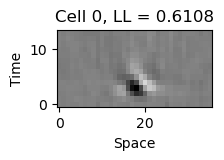

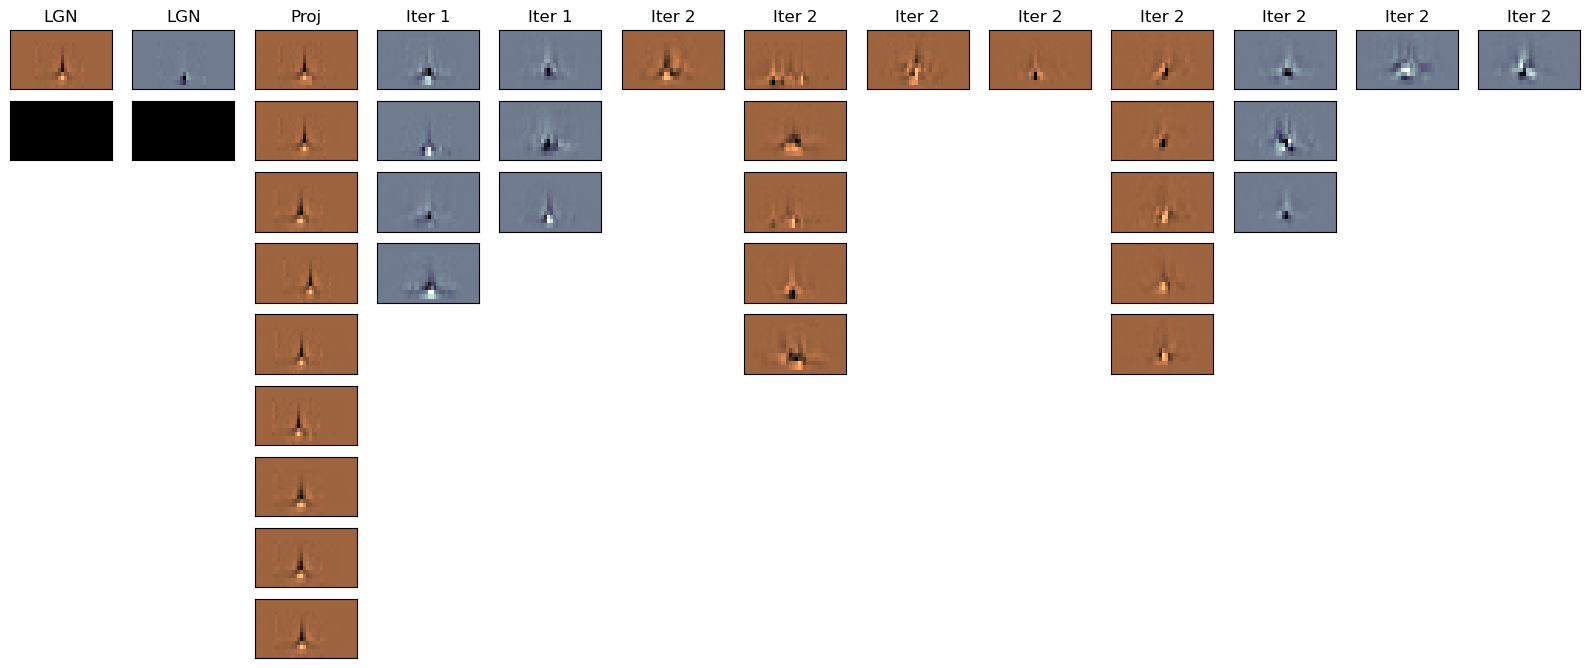

Direction-selective cell 2


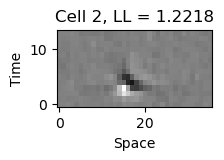

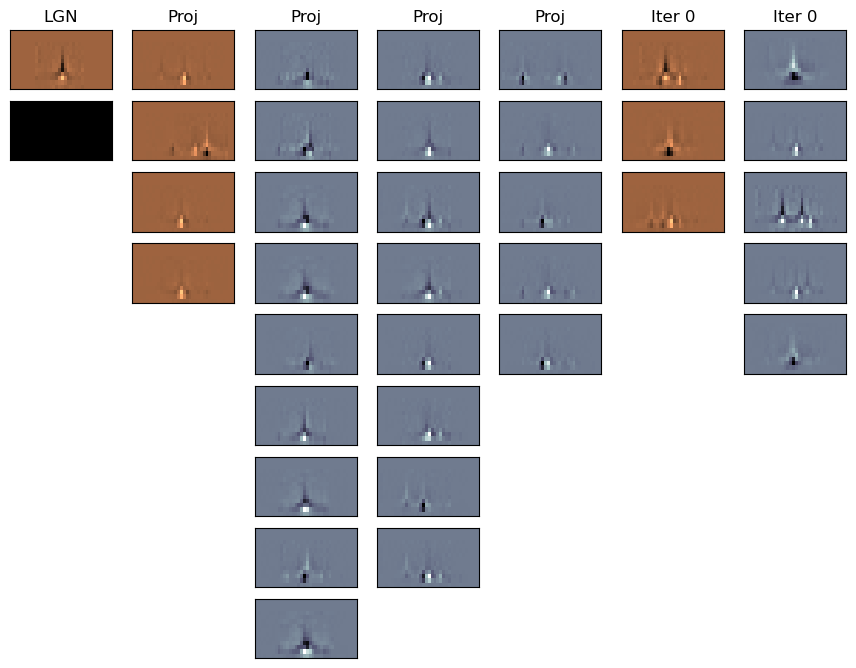

Direction-selective cell 63


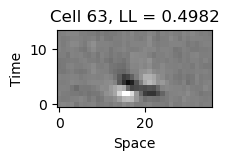

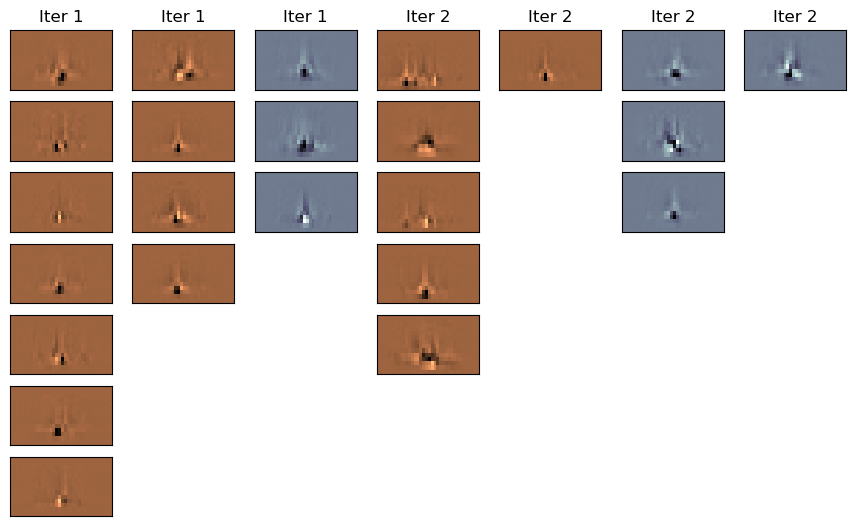

Direction-selective cell 87


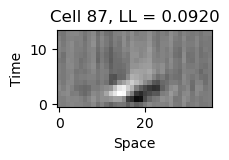

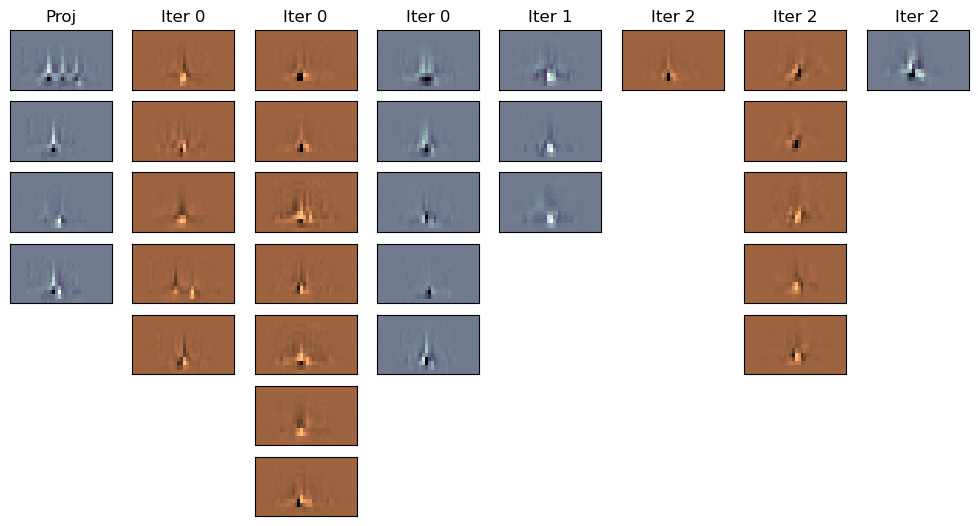

Non-selective cell 1


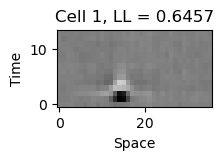

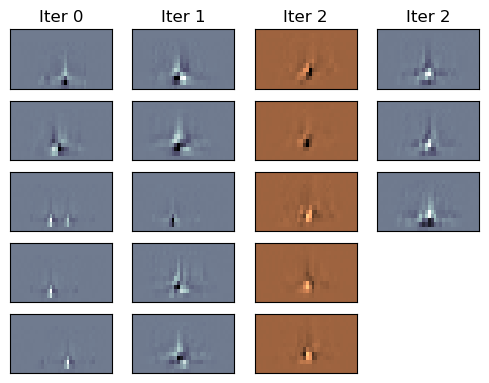

Non-selective cell 3


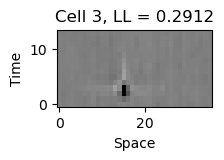

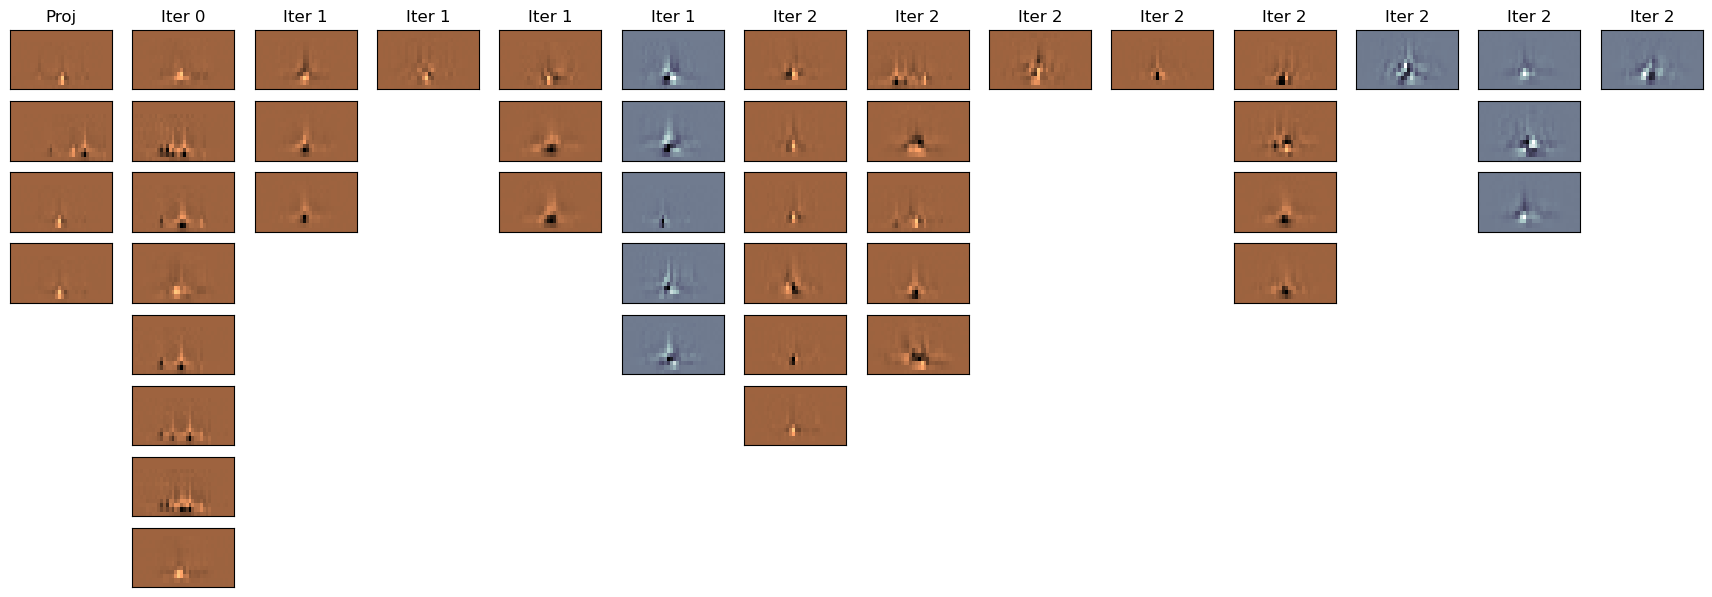

Non-selective cell 36


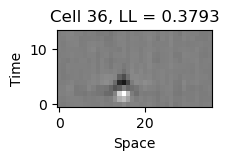

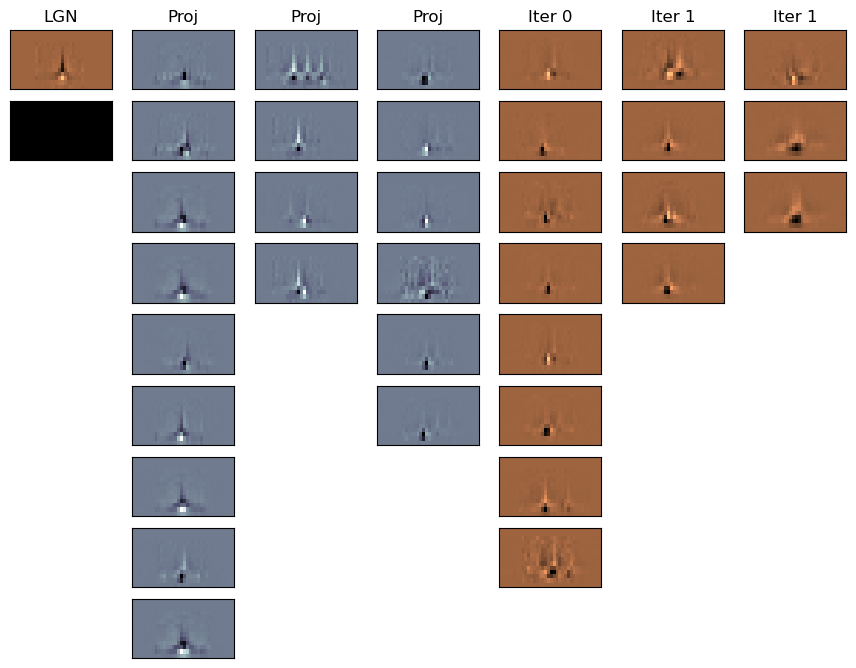

Non-selective cell 89


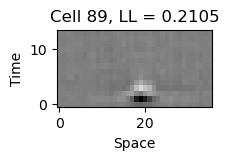

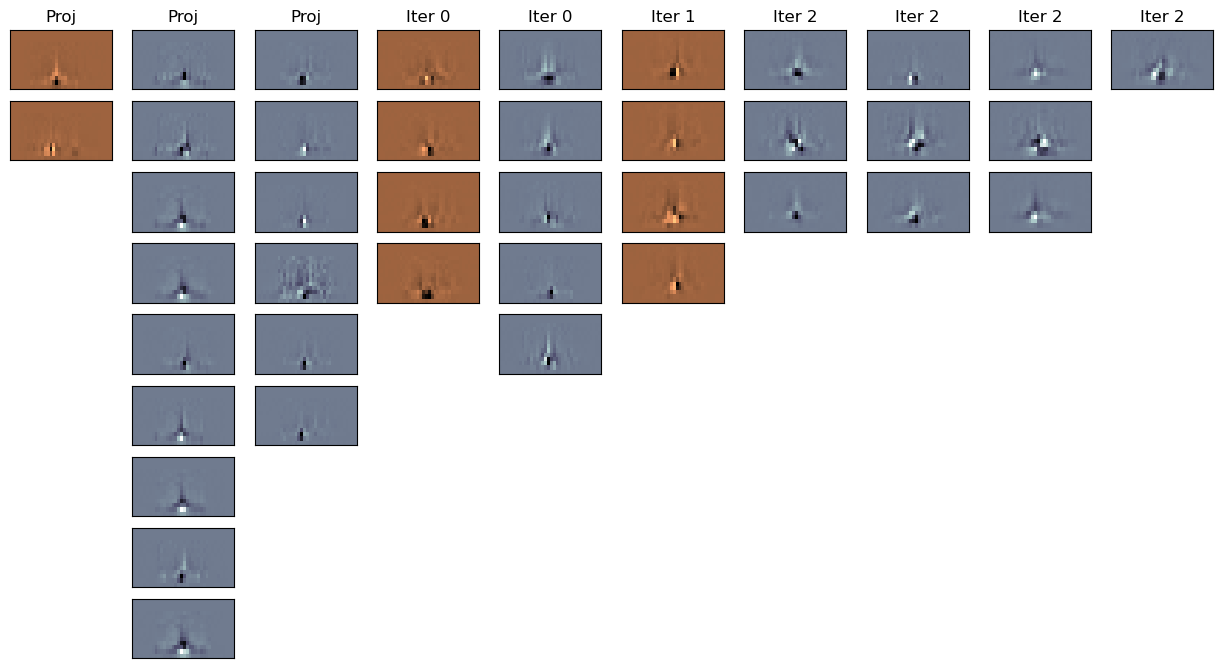

In [126]:
for i in range(len(dirsel_neurons)):
    typ = 'Direction-selective' if i < 4 else 'Non-selective'
    print(typ + ' cell %d' % dirsel_neurons[i])
    plot_jacobians(np.argwhere(np.abs(dirsel_weights[i]) > 0.1), neuron=dirsel_neurons[i])